## What's New

### Summary 

Brought to you by popular demand, this edition of `made-with-gs-quant` will showcase some of our newest features and capabilities. Going forward, look out for a `What's New` section in `made_with_gs_quant` that will highlight new additions.

The content of this notebook is split into:
* [1 - Let's get started with gs quant](#1---Let's-get-started-with-gs-quant)
* [2 - Cash flows](#2---Cash-flows)
* [3 - Portfolios](#3---Portfolios)
* [4 - Scenarios](#4---Scenarios)
* [5 - Compute](#4---Compute)

### 1 - Let's get started with gs quant
Start every session with authenticating with your unique client id and secret. If you don't have a registered app, create one [here](https://marquee.gs.com/s/developer/myapps/register). `run_analytics` scope is required for the functionality covered in this example. Below produced using gs-quant version 0.8.115.

In [1]:
from gs_quant.session import GsSession
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics',))

### 2 - Cash flows

Let's start with something small but impactful - ability to model future cashflows. You can simply use `CashFlows` as any of the other risk measures to get a dataframe of future cashflows.

In [2]:
from gs_quant.risk import Cashflows
from gs_quant.common import Currency, PayReceive
from gs_quant.instrument import IRSwaption

swaption = IRSwaption(PayReceive.Receive, '10y', Currency.USD, expiration_date='6m')
cf = swaption.calc(Cashflows)
cf.head()

,payment_date,accrual_start_date,accrual_end_date,payment_amount,notional,payment_type,floating_rate_option,floating_rate_designated_maturity,day_count_fraction,spread,rate,discount_factor
0,2021-02-03,2020-11-03,2021-02-03,74844.878468,100000000.0,Flt,USD-LIBOR-BBA,3m,0.255556,0.0,0.002929,0.999485
1,2021-05-04,2020-11-03,2021-05-04,-316822.584063,100000000.0,FIX,NA,NA,0.502778,NaN,0.006301,0.999338
2,2021-05-04,2021-02-03,2021-05-04,66302.366710,100000000.0,Flt,USD-LIBOR-BBA,3m,0.250000,0.0,0.002652,0.999338
3,2021-08-03,2021-05-04,2021-08-03,62077.155751,100000000.0,Flt,USD-LIBOR-BBA,3m,0.252778,0.0,0.002456,0.999188
4,2021-11-03,2021-05-04,2021-11-03,-313321.782029,100000000.0,FIX,NA,NA,0.497222,NaN,0.006301,0.999034


### 3 - Portfolios
I have used `Portfolio` wrappers in my previous analyses, so this one should be somewhat familiar. `Portfolio` makes working with many positions easier and allows risk to be viewed both at position level and aggregate level (more portfolio features like saving in the pipeline..look for it in `What's New` section in the new editions!)

Let's first define a portfolio - I will define a book of swaptions with varying strikes.

In [3]:
from gs_quant.markets.portfolio import Portfolio
from gs_quant.common import Currency, PayReceive
from gs_quant.instrument import IRSwaption

swaptions = [IRSwaption(PayReceive.Receive, '10y', Currency.USD, expiration_date='6m', strike=strike, 
                        name=strike) for strike in ('atm', 'atm-10', 'atm-25', 'atm-50')]

# create portfolio from list of instruments
portfolio = Portfolio(swaptions, name='swaption_port')

# resolve all the instruments in place
portfolio.resolve()

Now we can work with this portfolio the same way we do with an instrument - that is, we can price it or calculate any of the available risk measures on it. 

In [4]:
from gs_quant.risk import DollarPrice, IRVegaParallel
risks = portfolio.calc((DollarPrice, IRVegaParallel))

With `risks` in hand, we can examine these risks on an instrument level or aggregate level:

In [5]:
# all risks for a specific (in this case, first) instrument in the portfolio
print(risks[portfolio[0]])

# single risk for a specific (in this case, first) instrument in the portfolio
print(risks[portfolio[0]][DollarPrice])
# or...
print(risks[DollarPrice][portfolio[0]])

# aggregate risk for the portfolio
print(risks[IRVegaParallel].aggregate())

{DollarPrice (RiskMeasure): 1843835.5757294255, IRVegaParallel (RiskMeasure): 27825.70485206642}
1843835.5757294255
1843835.5757294255
89360.6453179445


Finally, we can convert our portfolio to a dataframe where each row will represent an instrument. 

In [6]:
frame = portfolio.to_frame()
frame.head(2)

floating_rate_spread  fee  \
portfolio     instrument                                       
swaption_port atm (IRSwaption)                      0.0  0.0   
              atm-10 (IRSwaption)                   0.0  0.0   

                                  fixed_rate_frequency                type  \
portfolio     instrument                                                     
swaption_port atm (IRSwaption)                      6m  AssetType.Swaption   
              atm-10 (IRSwaption)                   6m  AssetType.Swaption   

                                   fee_currency termination_date  \
portfolio     instrument                                           
swaption_port atm (IRSwaption)     Currency.USD       2030-11-03   
              atm-10 (IRSwaption)  Currency.USD       2030-11-03   

                                  floating_rate_frequency  \
portfolio     instrument                                    
swaption_port atm (IRSwaption)                         3m   
              atm-10 (IRSwaption)                      3m   

                                                    settlement effective_date  \
portfolio     instrument                                                        
swaption_port atm (IRSwaption)     SwapSettlement.Phys_CLEARED     2020-11-03   
              atm-10 (IRSwaption)  SwapSettlement.Phys_CLEARED     2020-11-03   

                                        asset_class  ...  \
portfolio     instrument                             ...   
swaption_port atm (IRSwaption)     AssetClass.Rates  ...   
              atm-10 (IRSwaption)  AssetClass.Rates  ...   

                                         fixed_rate_business_day_convention  \
portfolio     instrument                                                      
swaption_port atm (IRSwaption)     BusinessDayConvention.Modified_Following   
              atm-10 (IRSwaption)  BusinessDayConvention.Modified_Following   

                                   fixed_rate_day_count_fraction  \
portfolio     instrument                                           
swaption_port atm (IRSwaption)     DayCountFraction._30_OVER_360   
              atm-10 (IRSwaption)  DayCountFraction._30_OVER_360   

                                   expiration_date notional_amount  \
portfolio     instrument                                             
swaption_port atm (IRSwaption)          2020-10-30     100000000.0   
              atm-10 (IRSwaption)       2020-10-30     100000000.0   

                                          clearing_house     buy_sell  \
portfolio     instrument                                                
swaption_port atm (IRSwaption)     SwapClearingHouse.LCH  BuySell.Buy   
              atm-10 (IRSwaption)  SwapClearingHouse.LCH  BuySell.Buy   

                                  floating_rate_designated_maturity  \
portfolio     instrument                                              
swaption_port atm (IRSwaption)                                   3m   
              atm-10 (IRSwaption)                                3m   

                                      floating_rate_business_day_convention  \
portfolio     instrument                                                      
swaption_port atm (IRSwaption)     BusinessDayConvention.Modified_Following   
              atm-10 (IRSwaption)  BusinessDayConvention.Modified_Following   

                                  floating_rate_day_count_fraction  premium  
portfolio     instrument                                                     
swaption_port atm (IRSwaption)       DayCountFraction.ACT_OVER_360      0.0  
              atm-10 (IRSwaption)    DayCountFraction.ACT_OVER_360      0.0  

[2 rows x 26 columns]

We can append `RiskResults` as columns to this dataframe as we compute additional measures.

In [7]:
import pandas as pd

rks = pd.DataFrame(risks) 
rks.index = frame.index

pd.concat([frame, rks], axis=1)

floating_rate_spread  fee  \
portfolio     instrument                                       
swaption_port atm (IRSwaption)                      0.0  0.0   
              atm-10 (IRSwaption)                   0.0  0.0   
              atm-25 (IRSwaption)                   0.0  0.0   
              atm-50 (IRSwaption)                   0.0  0.0   

                                  fixed_rate_frequency                type  \
portfolio     instrument                                                     
swaption_port atm (IRSwaption)                      6m  AssetType.Swaption   
              atm-10 (IRSwaption)                   6m  AssetType.Swaption   
              atm-25 (IRSwaption)                   6m  AssetType.Swaption   
              atm-50 (IRSwaption)                   6m  AssetType.Swaption   

                                   fee_currency termination_date  \
portfolio     instrument                                           
swaption_port atm (IRSwaption)     Currency.USD       2030-11-03   
              atm-10 (IRSwaption)  Currency.USD       2030-11-03   
              atm-25 (IRSwaption)  Currency.USD       2030-11-03   
              atm-50 (IRSwaption)  Currency.USD       2030-11-03   

                                  floating_rate_frequency  \
portfolio     instrument                                    
swaption_port atm (IRSwaption)                         3m   
              atm-10 (IRSwaption)                      3m   
              atm-25 (IRSwaption)                      3m   
              atm-50 (IRSwaption)                      3m   

                                                    settlement effective_date  \
portfolio     instrument                                                        
swaption_port atm (IRSwaption)     SwapSettlement.Phys_CLEARED     2020-11-03   
              atm-10 (IRSwaption)  SwapSettlement.Phys_CLEARED     2020-11-03   
              atm-25 (IRSwaption)  SwapSettlement.Phys_CLEARED     2020-11-03   
              atm-50 (IRSwaption)  SwapSettlement.Phys_CLEARED     2020-11-03   

                                        asset_class  ... expiration_date  \
portfolio     instrument                             ...                   
swaption_port atm (IRSwaption)     AssetClass.Rates  ...      2020-10-30   
              atm-10 (IRSwaption)  AssetClass.Rates  ...      2020-10-30   
              atm-25 (IRSwaption)  AssetClass.Rates  ...      2020-10-30   
              atm-50 (IRSwaption)  AssetClass.Rates  ...      2020-10-30   

                                  notional_amount         clearing_house  \
portfolio     instrument                                                   
swaption_port atm (IRSwaption)        100000000.0  SwapClearingHouse.LCH   
              atm-10 (IRSwaption)     100000000.0  SwapClearingHouse.LCH   
              atm-25 (IRSwaption)     100000000.0  SwapClearingHouse.LCH   
              atm-50 (IRSwaption)     100000000.0  SwapClearingHouse.LCH   

                                      buy_sell  \
portfolio     instrument                         
swaption_port atm (IRSwaption)     BuySell.Buy   
              atm-10 (IRSwaption)  BuySell.Buy   
              atm-25 (IRSwaption)  BuySell.Buy   
              atm-50 (IRSwaption)  BuySell.Buy   

                                  floating_rate_designated_maturity  \
portfolio     instrument                                              
swaption_port atm (IRSwaption)                                   3m   
              atm-10 (IRSwaption)                                3m   
              atm-25 (IRSwaption)                                3m   
              atm-50 (IRSwaption)                                3m   

                                      floating_rate_business_day_convention  \
portfolio     instrument                                                      
swaption_port atm (IRSwaption)     BusinessDayConvention.Modified_Following   
              atm-10 (IRSwaption)  Busi

Note the last two columns in the frame are the risks we appended!

Want to see more portfolio examples? Refer to portfolio [examples here](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/tree/master/gs_quant/examples/02_portfolio/) and [previous editions](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/tree/master/gs_quant/made_with_gs_quant/) of `made_with_gs_quant`.

### 4 - Scenarios

The team has also invested to build our scenario capabilities. In particular we: (1) simplified `MarketDataShock` scenario (2) added aging or `carry` scenario (3) introduced composite scenarios. Let's look at an example of each.

##### Simple Market Shock

`MarketDataShockBasedScenario` is designed to allow users to shock any kind of market data. In this example we will shock the spot by 1bp. Note while before you had to specify each of the underlying curves used to build spot curve, you can now simply indicate `('IR', 'USD')`

In [8]:
from gs_quant.risk import MarketDataShockBasedScenario, MarketDataPattern, MarketDataShock, MarketDataShockType

ir_spot_scenario = MarketDataShockBasedScenario(
    shocks={
        MarketDataPattern('IR', 'USD'): MarketDataShock(MarketDataShockType.Absolute, 1e-4),  # 1 bp shock
        MarketDataPattern('IR Reset', 'USD-3m'): MarketDataShock(shock_type=MarketDataShockType.Absolute, value=1e-4),
    })

with ir_spot_scenario:
    spot_shock = portfolio.price()
    
print('Base price:        {:,.2f}'.format(risks[DollarPrice].aggregate())) # or portfolio.price().aggregate()
print('Spot shock price:  {:,.2f}'.format(spot_shock.aggregate()))

Base price:        4,237,917.02
Spot shock price:  4,130,856.93


##### Carry Scenario

The `CarryScenario` can be used to move the pricing date into the future. In order to do this we do two things: (1) project the market data forward in time (either keeping spot rates constant or fwd rates constant - more on this in a bit) to the new pricing date and (2) lifecycle the trades so that any fixings or expiries that happen between today’s date and the target future date have been handled.

In [9]:
from gs_quant.markets import PricingContext
from gs_quant.risk import CarryScenario

carry_scenario = CarryScenario(date='1m')
with carry_scenario:
    carry_shock = portfolio.price()
    
print('Base price:        {:,.2f}'.format(risks[DollarPrice].aggregate())) # portfolio.price().aggregate()
print('Carry shock price: {:,.2f}'.format(carry_shock.aggregate()))

Base price:        4,237,917.02
Carry shock price: 3,612,064.19


##### Combined Scenarios

We can now combine these two scenarios to produce a 'carry then bump' scenario (note all permutations aren't supported yet but are underway):

In [10]:
with carry_scenario, ir_spot_scenario:
    carry_then_bump_shock = portfolio.price()
    
print('Base price:            {:,.2f}'.format(risks[DollarPrice].aggregate())) # portfolio.price().aggregate()
print('Carry then bump price: {:,.2f}'.format(carry_then_bump_shock.aggregate()))

Base price:            4,237,917.02
Carry then bump price: 3,468,154.94


More on scenario examples in the [examples folder](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/tree/master/gs_quant/examples/04_scenario/) in the gs-quant repo.

### 5 - Compute

Finally to optimize both speed and performance we have improved our async and batch framework.

In a nutshell, `async` allows the requests to be processed in parallel and `batch` allows them to be grouped together and avoid timeouts for particularly large requests.

Additionally, multiple contexts can be controlled by a 'master' `PricingContext` to batch requests together in order to also avoid timeouts and sending too many requests. For example of this please see [`4-Delta Hedging`](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/blob/master/gs_quant/made_with_gs_quant/4-Delta%20Hedging.ipynb) notebook. 

For now, let's look at a simpler example using the scenarios we discussed in the previous section. Here we will look at how the price of our portfolio evolved as we move it 21 days forward in time both keeping spot rates constant (`roll_to_fwds=False`) and fwd rates constant (`roll_to_fwds=True`). Let's use a `PricingContext` with batch mode to organize these requests.

In [11]:
from gs_quant.markets import PricingContext

# note nest_asyncio required when using is_batch=True
import nest_asyncio
nest_asyncio.apply()

roll_to_spot = []
roll_to_fwd = []

with PricingContext(is_batch=True):
    for time_shift in range(22):
        with PricingContext(is_async=True), CarryScenario(time_shift, roll_to_fwds=True):
            roll_to_spot.append(portfolio.price())
        with PricingContext(is_async=True), CarryScenario(time_shift, roll_to_fwds=False):
            roll_to_fwd.append(portfolio.price())

Let's now visualize the result:

Text(0, 0.5, 'PV')

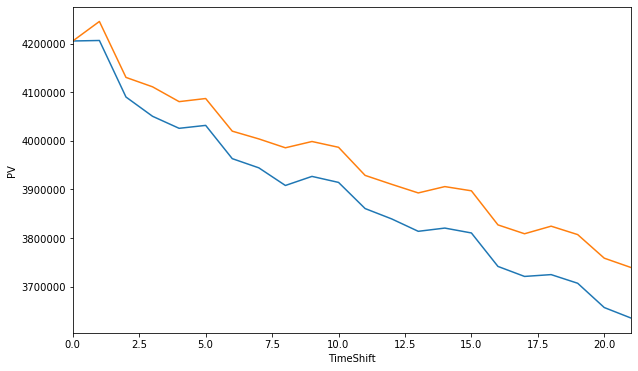

In [13]:
import matplotlib.pyplot as plt
import numpy as np

pd.Series([r.aggregate() for r in roll_to_spot], name='Roll to Spot', dtype=np.dtype(float)).plot(figsize=(10, 6))
pd.Series([r.aggregate() for r in roll_to_fwd], name='Roll to Fwd', dtype=np.dtype(float)).plot(figsize=(10, 6))
plt.xlabel('TimeShift')
plt.ylabel('PV')

That's all for this edition - please keep sharing your feedback on what would make `gs-quant` even more useful for you as well as suggestions for `made_with_gs_quant` you would like to see in the future.

Happy coding!